In [21]:
import base64
from typing import Annotated, List, Union

# import magic
import requests
from IPython.display import Image, display
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, StateGraph
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, create_react_agent, tools_condition
from pydantic import BaseModel, Field
from typing_extensions import TypedDict


from typing import Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain_core.tools import BaseTool
from langchain_core.tools import tool
from langchain_core.tools.base import ArgsSchema
from pydantic import BaseModel, Field

# from ultralytics import YOLO

In [22]:
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)

## Research Agent

### State

In [23]:
class ResearchAgentState(MessagesState):
    """The state of the agent."""
    number_of_steps: int

### Tools

In [24]:
from langchain_community.tools import (
    ArxivQueryRun,
    DuckDuckGoSearchResults,
    WikipediaQueryRun,
)
from langchain_community.utilities import (
    ArxivAPIWrapper,
    DuckDuckGoSearchAPIWrapper,
    WikipediaAPIWrapper,
)

In [25]:
arxiv_wrapper = ArxivAPIWrapper(
    top_k_results=2, doc_content_chars_max=1000
)
arxiv = ArxivQueryRun(
    api_wrapper=arxiv_wrapper,
    description="Search for papers on a given topic using Arxiv"
)
arxiv.invoke("Rotary Positional Encoding")

'Published: 2025-03-03\nTitle: Rotary Outliers and Rotary Offset Features in Large Language Models\nAuthors: André Jonasson\nSummary: Transformer-based Large Language Models (LLMs) rely on positional encodings\nto provide sequence position information to their attention mechanism. Rotary\nPositional Encodings (RoPE), which encode relative position by rotating queries\nand keys, have become widely used in modern LLMs. We study the features and\npatterns that emerge in queries and keys when using rotary embeddings. Our\nanalysis reveals consistent patterns within the same model across layers and\nattention heads and across different models and architectures. We present and\napply analysis techniques and show how the queries and keys use RoPE to\nconstruct various attention patterns, including attention sinks. We find and\nanalyze outliers across models in queries and keys and find that they are\nlikely to be found in rotary features with partial cycles. We derive bounds\nthat tell us wha

In [26]:
wikipedia_wrapper = WikipediaAPIWrapper()
wikipedia = WikipediaQueryRun(
    api_wrapper=wikipedia_wrapper,
    description="Search for information on a given topic using Wikipedia"
)
wikipedia.invoke("machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML finds application in many fields, including natural language processing, computer vision, speech recognition, email filtering, agriculture, and medicine. The application of ML to business problems is known as predictive analytics.\nStatistics and mathematical optimisation (mathematical programming) methods comprise the foundations of machine learning. Data mining is a related field of study, focusing on exploratory data analysis (EDA) via unsupervised learning. \nFrom a theoretical viewpoint, p

In [27]:
duck_search = DuckDuckGoSearchResults(output_format="list")
duck_search.invoke("Rotary Positional Encoding")

[{'snippet': 'Unlike traditional positional embeddings, such as sinusoidal encodings used in transformers, which represent the absolute positions of tokens, Rotary Positional Embeddings (RoPE) are designed...',
  'title': 'A Deep Dive into Rotary Positional Embeddings (RoPE): Theory and ...',
  'link': 'https://medium.com/@parulsharmmaa/understanding-rotary-positional-embedding-and-implementation-9f4ad8b03e32'},
 {'snippet': 'Rotary Positional Encodings (RoPE, used in Llama models): Uses constant vectors built with rotational matrices Relative Positional Encodings (used in T5 and MPT): Based on distances between tokens rather than absolute positions Attention with Linear Bias (ALiBi, used in Falcon models): A bias term added to attention scores based on token distances',
  'title': 'Positional Encodings in Transformer Models',
  'link': 'https://machinelearningmastery.com/positional-encodings-in-transformer-models/'},
 {'snippet': 'One of the most popular types of encoding used today i

### Graph

In [28]:
from langchain_core.runnables import RunnableConfig
import json
from langchain_core.messages import ToolMessage
tools = [arxiv, wikipedia, duck_search]
tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def tool_node(state: ResearchAgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(
            tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_research_agent(
    state: ResearchAgentState,
    config: RunnableConfig,
):
    llm: ChatOpenAI = ChatOpenAI(
        base_url="http://127.0.0.1:1234/v1",
        temperature=0,
        api_key="not-needed"
    ).bind_tools(tools)
    system_prompt = SystemMessage(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    )
    response = llm.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: ResearchAgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

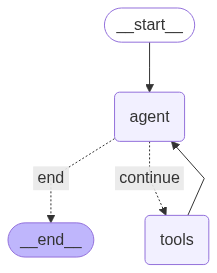

In [29]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Define a new graph
workflow = StateGraph(ResearchAgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_research_agent)
workflow.add_node("tools", tool_node)

# Set start node : start -> agent
workflow.set_entry_point("agent")
# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "end": END,
    },
)

# We now add a normal edge from ‘tools‘ to ‘agent‘.
# This means that after ‘tools‘ is called, ‘agent‘ node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
ResearchAgent = workflow.compile()
display(Image(ResearchAgent.get_graph().draw_mermaid_png()))

In [30]:
# Create our initial message dictionary
inputs = {"messages": [("user", "How is the weather in Vietnam?")]}

# call our graph with streaming to see the steps

for state in ResearchAgent.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

How is the weather in Vietnam?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (263786165)
 Call ID: 263786165
  Args:
    query: current weather in Vietnam
================================= Tool Message =================================
Name: duckduckgo_results_json

[{"snippet": "Vietnam - Detailed weather forecast for today. Comprehensive weather report for today for all locations.", "title": "Weather today - Vietnam", "link": "https://www.weather-atlas.com/en/vietnam"}, {"snippet": "The weather today in Vietnam will be very hot with temperatures reaching 34 \u00b0 C. During the evening and night time the temperatures will drop to 26 \u00b0 C. For deep dive information check out our hourly weather forecast for today down the page.", "title": "Vietnam local weather (live): today, hourly weather", "link": "https://www.weather25.com/as